# Regression with a mixture density network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from mdn_class import MDN_class
from util import gpu_sess,nzr
%matplotlib inline
print ("Packages loaded.")

Packages loaded.


### Train

MDN instantiated.


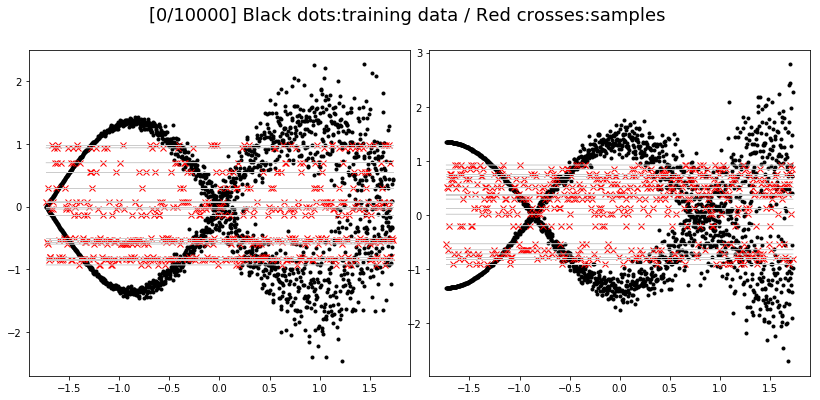

[000/10000] cost:215273458106368.0000


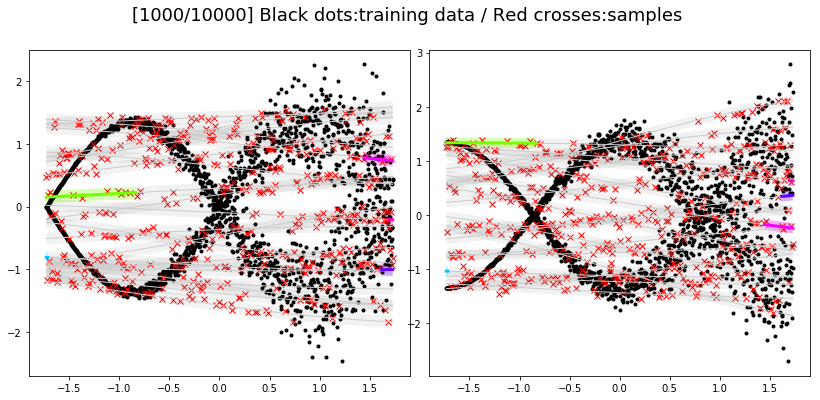

[1000/10000] cost:11.7485


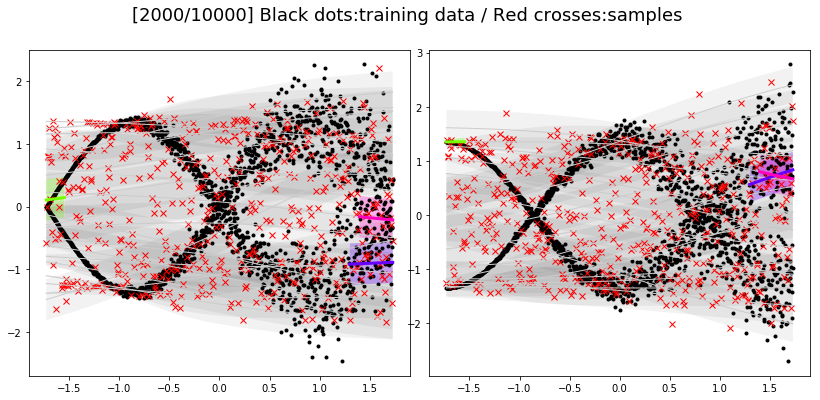

[2000/10000] cost:1.9051


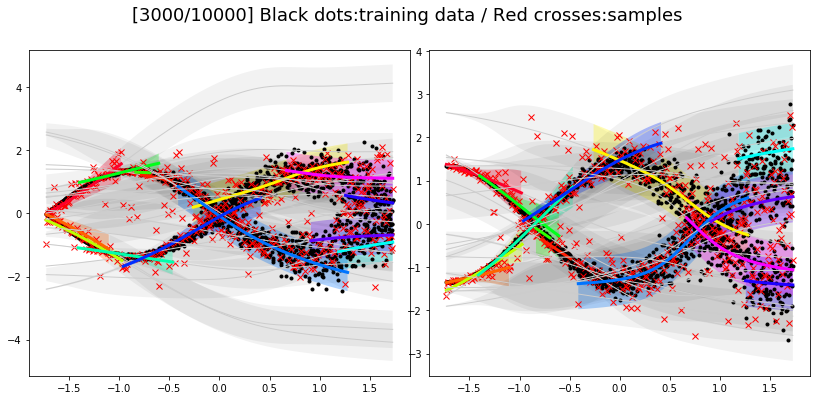

[3000/10000] cost:0.5833


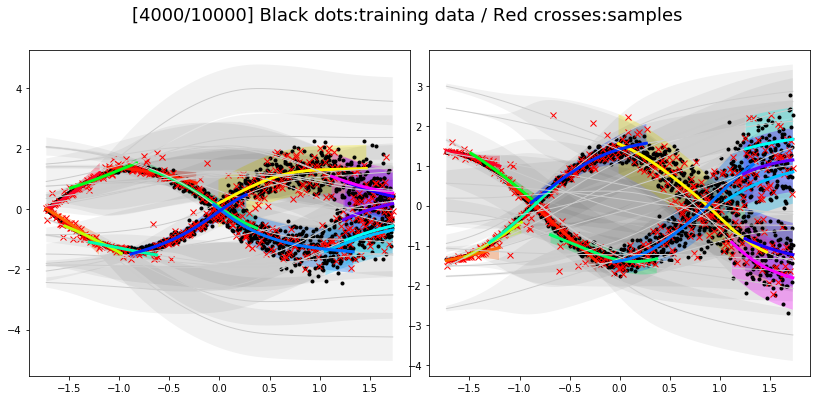

[4000/10000] cost:0.0207


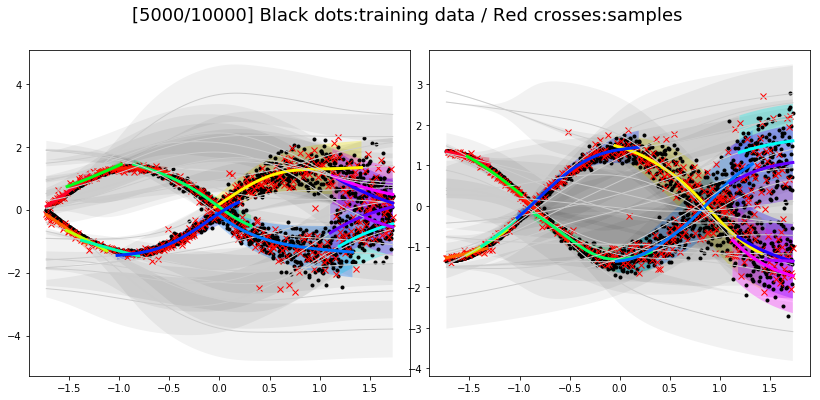

[5000/10000] cost:0.0698


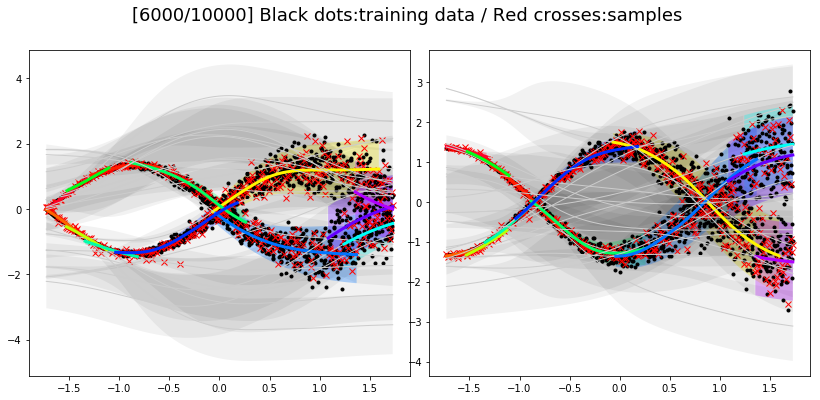

[6000/10000] cost:-0.3421


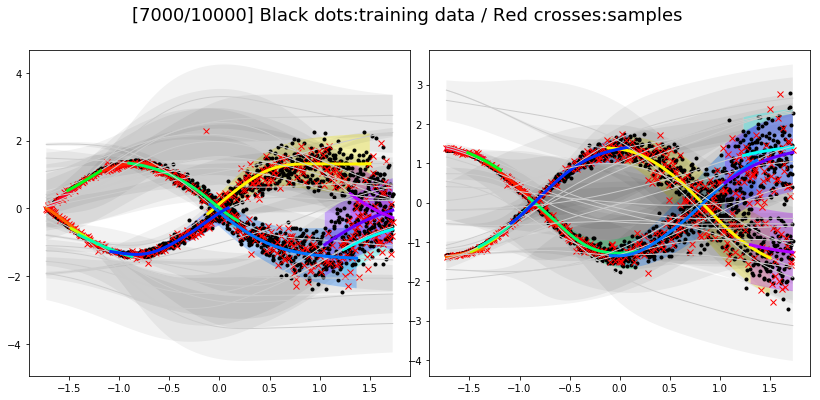

[7000/10000] cost:-0.3285


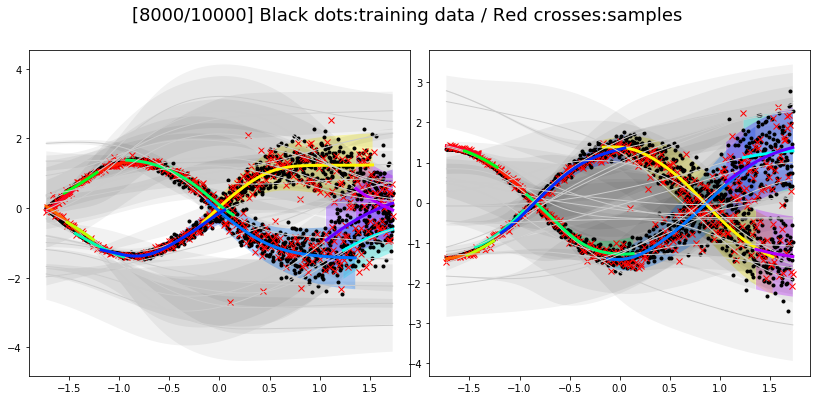

[8000/10000] cost:0.1944


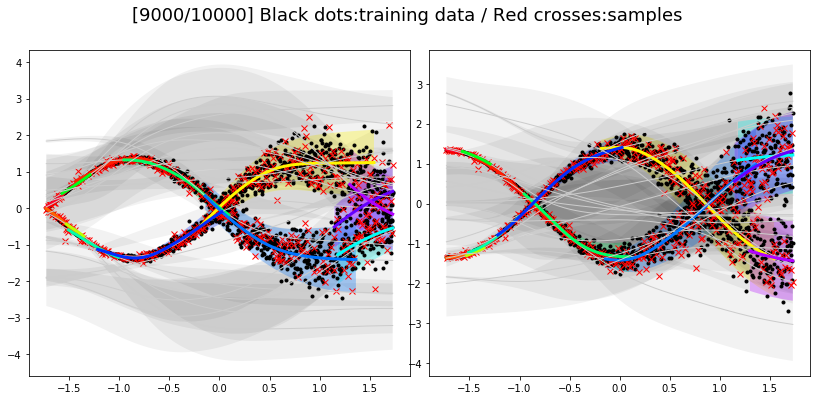

[9000/10000] cost:-0.5809


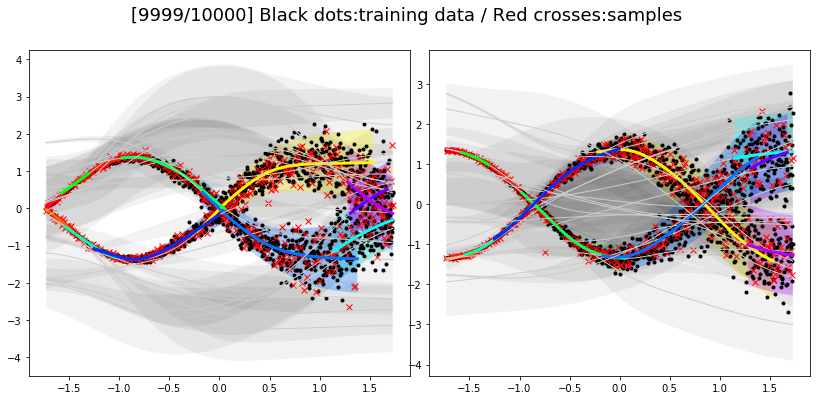

[9999/10000] cost:-0.4760


In [2]:
# Instantiate the MDN class 
tf.reset_default_graph() # Reset graph
tf.set_random_seed(seed=1)
np.random.seed(seed=1)
sess = gpu_sess()
M = MDN_class(_name='mdn',_x_dim=1,_y_dim=2,_k=20,_hids=[64,64],_actv=tf.nn.tanh,
              _sig_max=0.5,_SCHEDULE_SIG_MAX=True,
              _sess=sess,_VERBOSE=False)
print ("MDN instantiated.")

# Training data
x_min,x_max,n_train_half,y_max,var_scale = 0,100,1000,100,0.5 
x_train = np.linspace(x_min,x_max,n_train_half).reshape((-1,1)) # [1000 x 1]
y_train = np.concatenate((y_max*np.sin(2.0*np.pi*x_train/(x_max-x_min)),
                          y_max*np.cos(2.0*np.pi*x_train/(x_max-x_min))),axis=1) # [1000 x 2]
x_train,y_train = np.concatenate((x_train,x_train),axis=0),np.concatenate((y_train,-y_train),axis=0)
n_train = y_train.shape[0]
y_train = y_train + var_scale*y_max*np.random.randn(n_train,2)*np.square(x_train/x_max) # add noise 
nzr_x_train = nzr(x_train)
x_train = nzr_x_train.get_nzdval(x_train) # normalize training input
y_train = nzr(y_train).nzd_data # normalize training output 

# Train the mixture density network 
max_iter = 10000
x_test = np.linspace(x_min,x_max,500).reshape((-1,1))
x_test = nzr_x_train.get_nzdval(x_test) # normalize test input
M.train(_x_train=x_train,_y_train=y_train,_x_test=x_test,_max_iter=max_iter,_pi_th=0.1,
        _SHOW_EVERY=10,_figsize=(14,6))